Non parametric estimation of a Hawkes process with a single exponential kernel

Simulation of the process

In [1]:
import numpy as np

from tick.hawkes import SimuHawkes, HawkesKernelSumExp, HawkesKernelExp, SimuHawkesExpKernels
from tick.plot import plot_point_process, plot_hawkes_kernels

import matplotlib.pyplot as plt

In [2]:
decay_exp = 0.3
adjacency_exp = np.array([[0.5]])
baseline_exp = [0.5]
end_time_exp = 1e5

In [3]:
hawkes_exp = SimuHawkesExpKernels(
    adjacency=adjacency_exp, decays=decay_exp, baseline=baseline_exp,
    end_time=end_time_exp, verbose=True, seed=1039)
hawkes_exp.track_intensity(0.1)
hawkes_exp.simulate()

--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 5.19e-01 seconds.


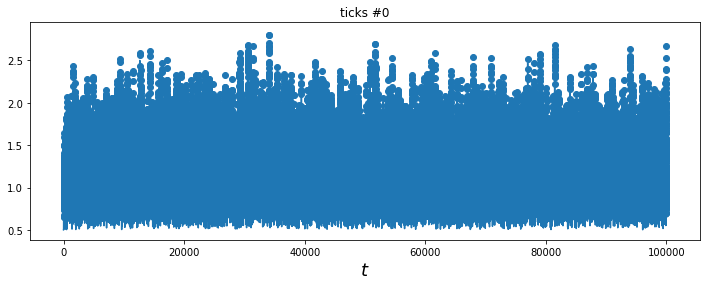

In [4]:
plot_point_process(hawkes_exp, n_points=50000)
plt.show()

Estimation with non parametric estimation method (EM algorithm)

In [5]:
from tick.plot import plot_basis_kernels
from tick.hawkes import HawkesBasisKernels

In [6]:
C = 1e-2 # a penalty parameter
kernel_size = 20 # kernel function is piecewise with 10 subintervals
max_iter = 100 # maximum iterations of the solver

In [7]:
kernel_support = 10 # support of the kernel
n_basis = 1 # one basis kernel

In [8]:
em = HawkesBasisKernels(kernel_support, n_basis=n_basis,
                        kernel_size=kernel_size, C=C,
                        n_threads=0, max_iter=max_iter,
                        verbose=True, ode_tol=1e-5)

In [9]:
em.fit(hawkes_exp.timestamps)

Launching the solver HawkesBasisKernels...
  n_iter  | rel_baseline | rel_amplitudes | rel_basis_kernels
        0 |     2.95e-01 |       1.44e-01 |          1.44e-01
       10 |     1.02e-02 |       8.28e-03 |          2.17e-02
       20 |     6.81e-03 |       4.11e-03 |          1.40e-02
       30 |     3.71e-03 |       1.65e-03 |          8.59e-03
       40 |     1.85e-03 |       4.36e-04 |          6.08e-03
       50 |     9.14e-04 |       1.26e-04 |          4.99e-03
       60 |     4.44e-04 |       3.98e-04 |          4.19e-03
       70 |     1.89e-04 |       5.42e-04 |          3.40e-03
       80 |     4.62e-05 |       6.20e-04 |          2.68e-03
       90 |     2.89e-05 |       6.59e-04 |          2.10e-03
      100 |     6.33e-05 |       6.75e-04 |          1.68e-03
Done solving using HawkesBasisKernels in 5.725124835968018 seconds


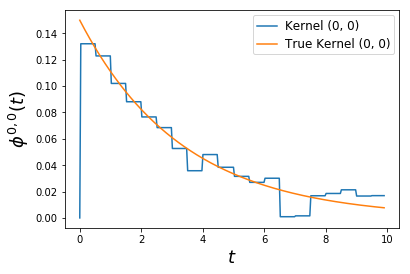

In [10]:
plot_hawkes_kernels(em, hawkes=hawkes_exp, support=9.9)
plt.show()

This non-parametric estimation works pretty well but needs a large dataset (end_time > 1e5) to converge.

Alternative method

In [25]:
from tick.hawkes import  HawkesEM

em_alt = HawkesEM(kernel_support, kernel_size=12, n_threads=0, verbose=True, tol=1e-4)
em_alt.fit(hawkes_exp.timestamps)

Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     4.50e-01 |   4.48e-01
       10 |     1.19e-02 |   4.67e-02
       20 |     5.21e-03 |   1.35e-02
       30 |     1.82e-03 |   4.80e-03
       40 |     7.92e-04 |   3.01e-03
       50 |     4.57e-04 |   2.35e-03
       60 |     3.05e-04 |   1.89e-03
       70 |     2.06e-04 |   1.48e-03
       80 |     1.30e-04 |   1.13e-03
       90 |     7.24e-05 |   8.44e-04
      100 |     3.15e-05 |   6.28e-04
Done solving using HawkesEM in 0.38289880752563477 seconds


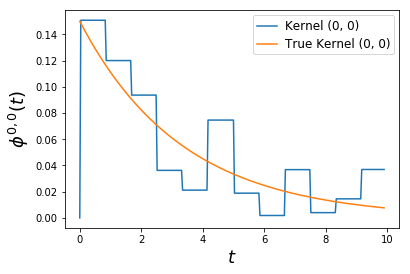

In [26]:
plot_hawkes_kernels(em_alt, hawkes=hawkes_exp, support=9.9)
plt.show()

With time_obs = 1e3 (~ 800 timestamps) the alternative method gives a result, but with pretty large error.

In [27]:
np.size(hawkes_exp.timestamps)

870

Moreover, we have to make a balance between the number of bins in the piecewise estimation, the time horizon and the precision of the solver.

In [29]:
em_alt.baseline # true baseline = 0.5

array([0.42821071])

Using conditional law

In [21]:
from tick.hawkes import HawkesConditionalLaw

support = 50

e = HawkesConditionalLaw(claw_method="log",
                         delta_lag=0.1, min_lag=0.002, max_lag=100,
                         quad_method="log",
                         n_quad=50, min_support=0.002, max_support=support,
                         n_threads=-1)

e.incremental_fit(hawkes_exp.timestamps)
e.compute()

/home/benjamin/anaconda3/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1144: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)


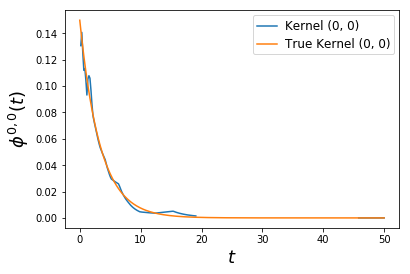

In [22]:
plot_hawkes_kernels(e, hawkes=hawkes_exp, min_support=0.002, support=support)
plt.show()

/home/benjamin/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


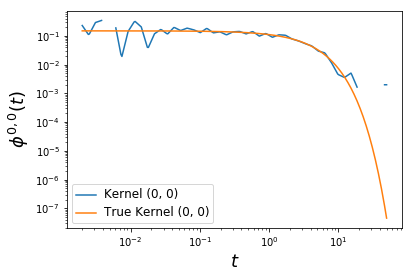

In [23]:
plot_hawkes_kernels(e, log_scale=True, hawkes=hawkes_exp, min_support=0.002, support=support)
plt.show()

This method converges pretty well and is suitable for detecting power laws but needs also a lot of data to work.